In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from copy import deepcopy
from delase import DeLASE
from delase.metrics import mase
from hydra import compose, initialize
from matplotlib import font_manager
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import socket
import sys
from tqdm.auto import tqdm

sys.path.append('..')
from data_utils import get_delase_results, get_delase_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, get_section_info, load_session_data, load_window_from_chunks

plt.style.use('../sci_style.mplstyle')
hostname = socket.gethostname()
if 'endeavour' in hostname:
    font_path = "/usr/share/fonts/TTF/Arial.TTF"
else:
    font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [3]:
with initialize(version_base="1.3", config_path="../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [193]:
cfg.params.data_class = 'leverOddball'
# session = "PEDRI_Ketamine_20220222"
session = "SPOCK_Ketamine_20210715"

# cfg.params.data_class = 'propofolPuffTone'
# session = 'Mary-Anesthesia-20160809-01'

In [194]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, ['sessionInfo', 'electrodeInfo', 'lfp', 'lfpSchema', 'trialInfo'], data_class=cfg.params.data_class)
session_info, electrode_info, lfp, lfp_schema, trial_info = session_vars['sessionInfo'], session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['trialInfo']

Loading data: ['sessionInfo', 'electrodeInfo', 'lfp', 'lfpSchema', 'trialInfo']...
sessionInfo : dict with keys[Properties,date,dose,drug,expType,infusionEnd,infusionStart,numCorrect,numTrials,pctCorrect,session,subject,tasks,]

electrodeInfo : dict with keys[Properties,area,array,channel,chnlID,electrode,file,gridLoc,hasLFP,hemisphere,numUnits,session,]

lfp : numpy.array(21141618,128,) of type float64

lfpSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

trialInfo : dict with keys[Properties,blockNum,condition,lvr_correct,lvr_outcome,lvr_reactionTime,lvr_responseDir,lvr_responseTime,lvr_rewardTime,lvr_toneOffset,lvr_toneOnset,odd_blockStd,odd_blockType,odd_globalOddball,odd_localOddball,odd_sequence,odd_sequenceEnd,odd_sequenceStart,odd_subblockType,odd_toneOffsets,odd_toneOnsets,odd_trialInBlock,refTime,session,task,trial,trialEnd,trialStart,]

Data loaded (took 114.36 seconds)


# Find Bad Electrodes

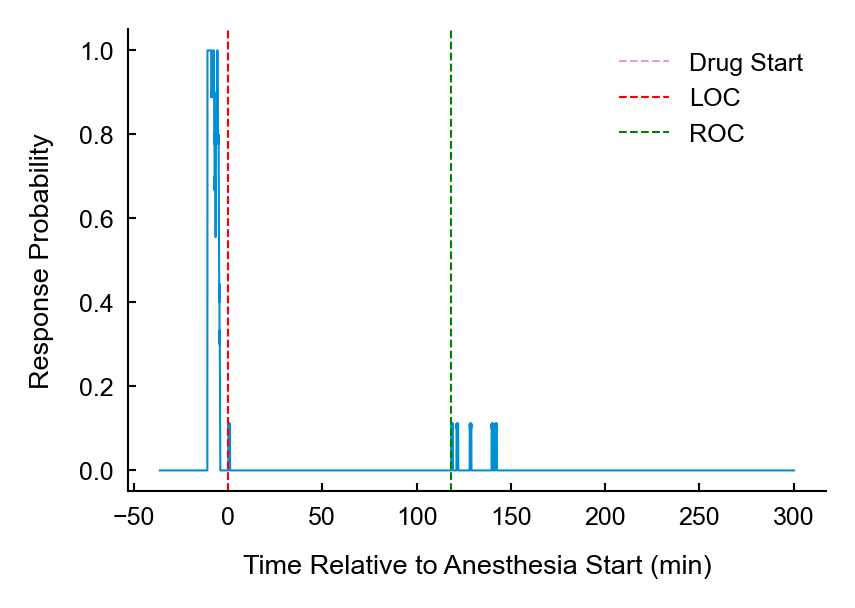

In [198]:
if 'propofol' in cfg.params.data_class:
    loc = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
    roc = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    ropap = roc
elif 'lever' in cfg.params.data_class:
    lever_window = 60
    stride = 0.1
    loc_thresh = 0
    roc_thresh = 0
    ropap_thresh = 0.25

    lever_starts = trial_info['trialStart'][trial_info['task'] == 'lever']
    lever_ends = trial_info['trialEnd'][trial_info['task'] == 'lever']

    window_starts = np.arange(0, lever_ends[-1], stride)

    drug_start = session_info['drugStart'][0] if 'propofol' in cfg.params.data_class else session_info['infusionStart']
    pct_correct = np.zeros(len(window_starts))
    loc = int(window_starts[(window_starts >= drug_start) & (pct_correct <= loc_thresh)].min())

    for i, window_start in enumerate(window_starts):
        window_end = window_start + lever_window
        outcomes = trial_info['lvr_correct'][(lever_starts >= window_start) & (lever_ends <= window_end)]
        if len(outcomes) > 0:
            pct_correct[i] = outcomes.sum()/len(outcomes)

    roc = int(window_starts[(window_starts > loc + 10*60) & (pct_correct > roc_thresh)].min())
    # ropap = int(window_starts[(window_starts > loc + 10*60) & (pct_correct > ropap_thresh)].min())

    plt.plot((window_starts - drug_start)/60, pct_correct)
    plt.axvline(0, c='plum',label='Drug Start', linestyle='--')
    plt.axvline((loc - drug_start)/60, c='r', label='LOC', linestyle='--')
    plt.axvline((roc - drug_start)/60, c='g', label='ROC', linestyle='--')
    # plt.axvline((ropap - drug_start)/60, c='orange', label='ROPAP', linestyle='--')
    plt.xlabel('Time Relative to Anesthesia Start (min)')
    plt.ylabel('Response Probability')
    plt.legend()
    plt.show()

In [201]:
window = 15
wake_amplitude_thresh = 1
anesthesia_amplitude_thresh = 2
electrode_num_thresh = 1
window_starts = np.arange(0, T*dt - window, window)
window_df = []


for i, window_start in tqdm(enumerate(window_starts), total=len(window_starts)):
    window_end = window_start + window
    window_data = lfp[int(window_start/dt):int((window_end)/dt)]
    max_vals = (np.abs(window_data)).max(axis=0)
    if window_start <= loc or window_start >= roc:
        bad_electrodes = np.where(max_vals > wake_amplitude_thresh)[0]
        wake = True
    else:
        bad_electrodes = np.where(max_vals > anesthesia_amplitude_thresh)[0]
        wake = False 
    window_df.append(dict(
        window_start=window_start,
        window_end=window_end,
        max_vals=max_vals,
        bad_electrodes=bad_electrodes,
        num_bad_electrodes=len(bad_electrodes),
        noise_window = len(bad_electrodes) > electrode_num_thresh,
        wake=wake
    ))
    # if window_start == 750:
    #     print(max_vals)
    #     break
window_df = pd.DataFrame(window_df)

  0%|          | 0/1409 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(6, 3))

time_vals = (np.arange(lfp.shape[0])*dt - drug_start)/60

plt.subplot(2, 3, 1)
plt.hist(window_df.num_bad_electrodes, bins=20)
plt.xlabel('# Bad Electrodes')
plt.ylabel('# Windows')
plt.title(f"Distribution of Bad Electrode Counts", fontsize=6)

plt.subplot(2, 3, 2)
appearances = np.zeros(len(electrode_info['area']))
solo_appearances = np.zeros(len(electrode_info['area']))
for i, row in window_df.iterrows():
    appearances[row.bad_electrodes] += 1
    if row.num_bad_electrodes == 1:
        solo_appearances[row.bad_electrodes] += 1
plt.scatter(np.arange(len(appearances)), appearances, c='magenta')
plt.xlabel('Electrode #')
plt.ylabel('# Appearances')
plt.title(f"Electrode Appearances in Bad Windows\nNumber of Electrodes with an Appearance: {np.sum(appearances > 0)}", fontsize=6)

plt.subplot(2, 3, 3)

plt.scatter(np.arange(len(solo_appearances)), solo_appearances)
plt.xlabel('Electrode #')
plt.ylabel('# Appearances')
plt.title(f"Electrode Solo Appearances in Bad Windows\nNumber of Electrodes with a Solo Appearance: {np.sum(solo_appearances > 0)}", fontsize=6)

plt.subplot(2, 3, 4)
# plt.plot(lfp[:, 37])
ind = np.where(solo_appearances == np.max(solo_appearances[solo_appearances > 0]))[0][0]
plt.plot(time_vals, lfp[:, ind])
for i, row in window_df.iterrows():
    if row.noise_window:
        start = int(row.window_start/dt)
        end = int(row.window_end/dt)
        plt.plot(time_vals[start:end], lfp[start:end, ind], color='magenta')
plt.title(f"Example LFP from Electrode {ind}\nMaximum Number of Solo Appearances ({int(np.max(solo_appearances[solo_appearances > 0]))})", fontsize=6)
plt.axvline(0, c='plum',label='Drug Start', linestyle='--')
plt.axvline((loc - drug_start)/60, c='r', label='LOC', linestyle='--')
plt.axvline((roc - drug_start)/60, c='g', label='ROC', linestyle='--')
# plt.axvline((ropap - drug_start)/60, c='orange', label='ROPAP', linestyle='--')
# max_ind = np.abs(lfp[:, ind]).argmax()
# plt.plot(lfp[max_ind - 30000:max_ind + 30000, ind])

plt.subplot(2, 3, 5)
# plt.plot(lfp[:, 37])
ind = np.where(solo_appearances == np.min(solo_appearances[solo_appearances >= 0]))[0][-1]
plt.plot(time_vals, lfp[:, ind])
for i, row in window_df.iterrows():
    if row.noise_window:
        start = int(row.window_start/dt)
        end = int(row.window_end/dt)
        plt.plot(time_vals[start:end], lfp[start:end, ind], color='magenta')
plt.title(f"Example LFP from Electrode {ind}\nMinimum Number of Solo Appearances ({int(np.min(solo_appearances[solo_appearances > 0]))})", fontsize=6)
plt.axvline(0, c='plum',label='Drug Start', linestyle='--')
plt.axvline((loc - drug_start)/60, c='r', label='LOC', linestyle='--')
plt.axvline((roc - drug_start)/60, c='g', label='ROC', linestyle='--')
# plt.axvline((ropap - drug_start)/60, c='orange', label='ROPAP', linestyle='--')

plt.subplot(2, 3, 6)
for ind in np.where(solo_appearances > 0)[0]:
    max_ind = np.abs(lfp[:, ind]).argmax()
    plt.plot(lfp[max_ind - 5000:max_ind + 5000, ind])
    # plt.plot(lfp[:, ind])
plt.title(f"Electrodes with Solo Appearances", fontsize=6)

# max_ind = np.abs(lfp[:, ind]).argmax()
# plt.plot(lfp[max_ind - 30000:max_ind + 30000, ind])
plt.suptitle(f"Session: {session}, Window: {window}s\nAmplitude Thresholds: wake={wake_amplitude_thresh}, anesthesia={anesthesia_amplitude_thresh}, Electrode Threshold: {electrode_num_thresh}\nNumber of Noise Windows: {np.sum(window_df.noise_window)} out of {len(window_df)}", fontsize=8)
plt.tight_layout()
plt.show()

In [181]:
np.sum(window_df.num_bad_electrodes > 0)

np.int64(212)

In [182]:
len(window_df)

913

In [186]:
row = window_df.loc[window_df[((window_df.window_start - drug_start)/60 <= 90.8)].window_start.idxmax()]

In [188]:
row.window_start, row.window_end

(np.float64(7605.0), np.float64(7620.0))

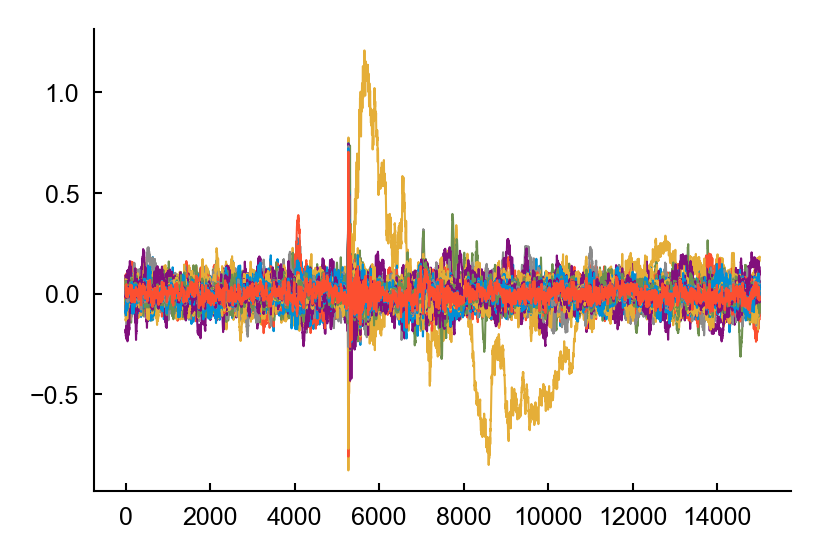

In [187]:
for i in range(lfp.shape[1]):
    plt.plot(lfp[int(row.window_start/dt):int(row.window_end/dt), i])

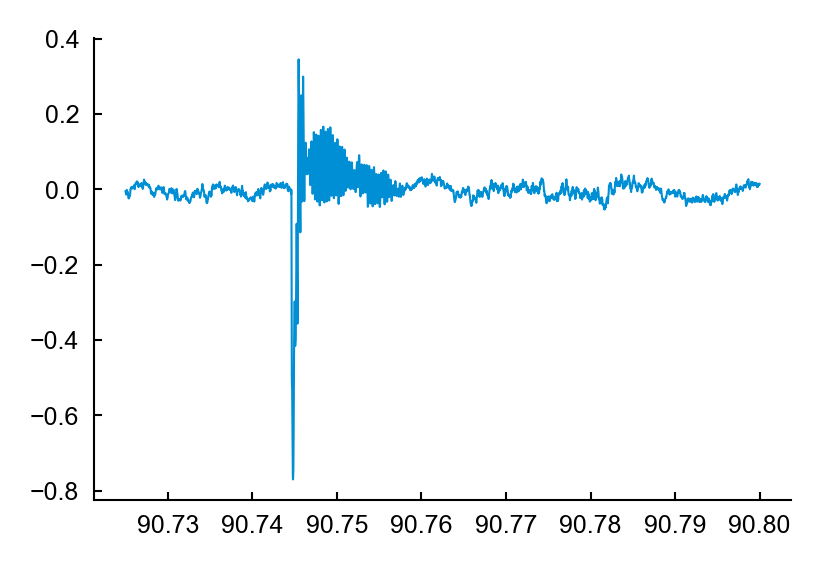

In [164]:
plot_inds = np.where((time_vals*60 >= (roc - drug_start)) & (time_vals <= 90.8) & (time_vals >= 90.725))[0]
plt.plot(time_vals[plot_inds], lfp[plot_inds, 86])

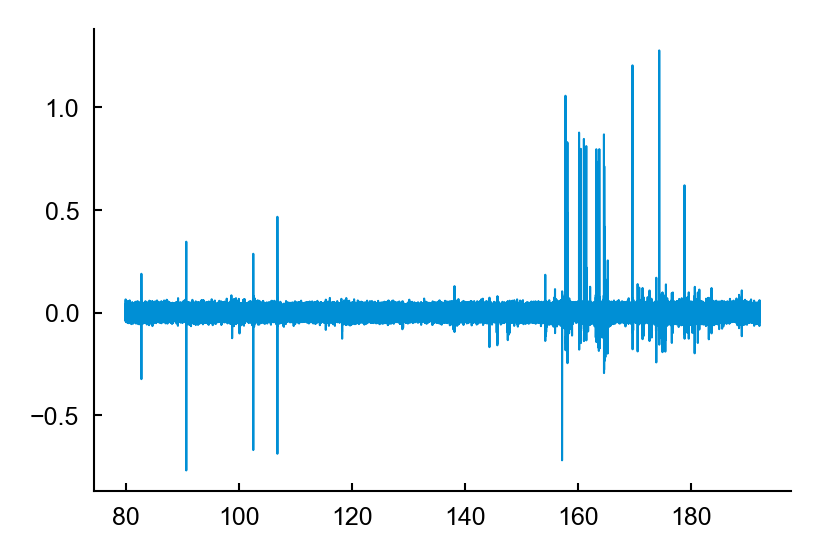

In [135]:
start = int((80*60 + drug_start)/dt)
end = int((1100*60 + drug_start)/dt)
plt.plot(time_vals[start:end], lfp[start:end, 86])

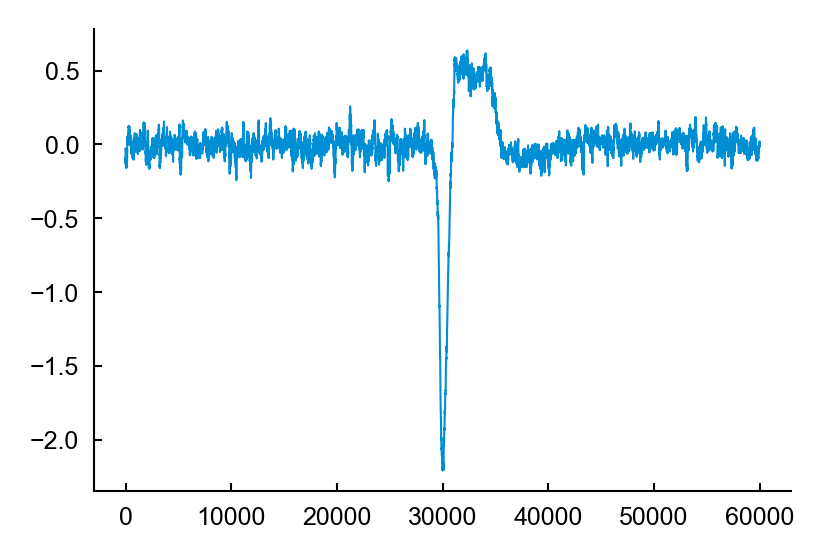

In [24]:
ind = 136
max_ind = np.abs(lfp[:, ind]).argmax()
plt.plot(lfp[max_ind - 30000:max_ind + 30000, ind])

# Windows with Noise Disturbance

In [101]:
noisy_windows = window_df[window_df.num_bad_electrodes >= window_flag_thresh]

In [102]:

ncols = 5
nrows = int(np.ceil(len(noisy_windows) / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharex=False, sharey=False)

num_electrodes_to_plot = 5

noisy_window_data = []
window_num = 0
for i, row in tqdm(noisy_windows.iterrows(), total=len(noisy_windows)):
    ax = axs.flat[window_num]
    window_start = row.window_start
    window_end = row.window_end
    noisy_window_data = lfp[int(window_start/dt):int((window_end)/dt)]
    electrodes_to_plot = row.max_vals.argsort()[::-1][:np.min([len(row.bad_electrodes), num_electrodes_to_plot])]

    ax.plot(np.arange(window_start, window_end, dt), noisy_window_data[:, electrodes_to_plot])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (mV)')
    ax.set_title(f'Window {i}\n{row.num_bad_electrodes} bad electrodes')

    window_num += 1
plt.tight_layout()
plt.suptitle(f'Noisy Windows\nSESSION={session}', y=1.02)
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 4500x0 with 0 Axes>

# Finding stray bad electrodes

In [19]:
filtered_window_df = window_df[window_df.num_bad_electrodes <= window_flag_thresh]

In [20]:
np.sum(filtered_window_df.num_bad_electrodes > 0)

np.int64(220)

In [21]:
bad_electrode_dfs = []
for electrode_num in np.arange(N):
    
    bad_electrode_dfs.append(filtered_window_df[filtered_window_df.bad_electrodes.apply(lambda x: electrode_num in x)])
    # if len(bad_electrode_dfs[-1]) == 1:
    #     break

In [22]:
np.sum(np.array([len(df) for df in bad_electrode_dfs]) > 0)

np.int64(33)

In [23]:
np.where(np.array([len(df) for df in bad_electrode_dfs]) == 1)

(array([  4,  11,  12,  18,  20,  25,  40,  43,  61,  68,  70, 101, 102,
        104, 112]),)

In [24]:
electrode_num = 4

In [25]:
bad_electrode_df = bad_electrode_dfs[electrode_num]

  0%|          | 0/1 [00:00<?, ?it/s]

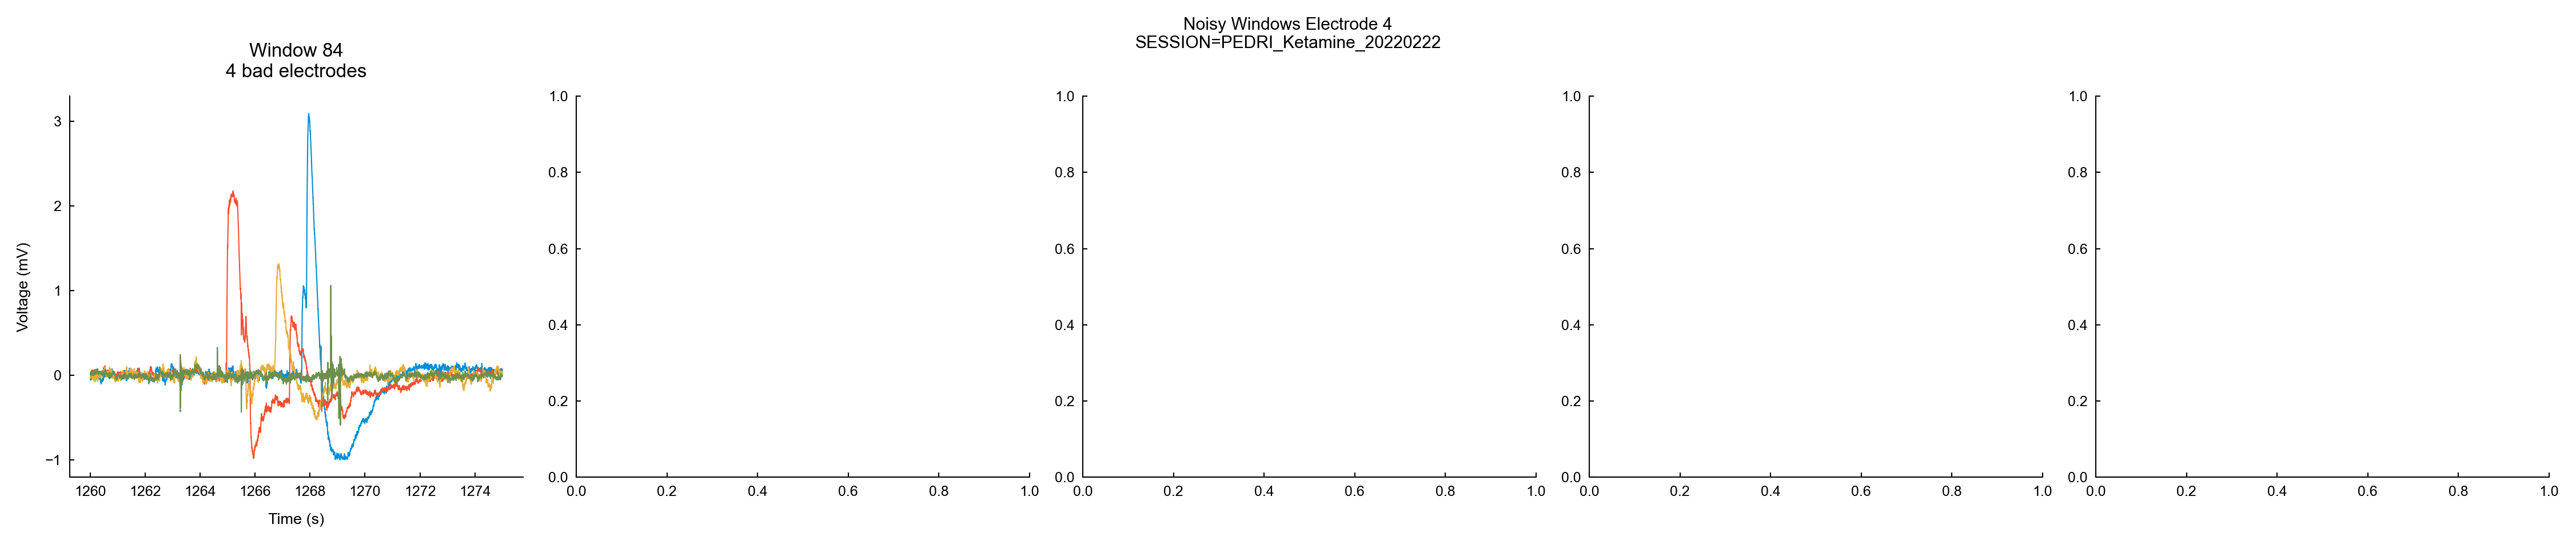

In [26]:

ncols = 5
nrows = int(np.ceil(len(bad_electrode_df) / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharex=False, sharey=False)

num_electrodes_to_plot = 5

window_num = 0
for i, row in tqdm(bad_electrode_df.iterrows(), total=len(bad_electrode_df)):
    ax = axs.flat[window_num]
    window_start = row.window_start
    window_end = row.window_end
    noisy_window_data = lfp[int(window_start/dt):int((window_end)/dt)]
    electrodes_to_plot = row.max_vals.argsort()[::-1][:np.min([len(row.bad_electrodes), num_electrodes_to_plot])]
    electrodes_to_plot = (np.concat(([electrode_num], [elec for elec in electrodes_to_plot if elec != electrode_num]))).astype(int)

    ax.plot(np.arange(window_start, window_end, dt), noisy_window_data[:, electrodes_to_plot])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (mV)')
    ax.set_title(f'Window {i}\n{row.num_bad_electrodes} bad electrodes')

    window_num += 1
plt.tight_layout()
plt.suptitle(f'Noisy Windows Electrode {electrode_num}\nSESSION={session}', y=1.02)
plt.show()

In [27]:
electrode_num

4

In [28]:
time_vals = np.arange(0, T*dt, dt)

In [29]:
noisy_times = np.array([False]*len(time_vals))
for i,row in noisy_windows.iterrows():
    noisy_times[(time_vals >= row.window_start) & (time_vals < row.window_end)] = True

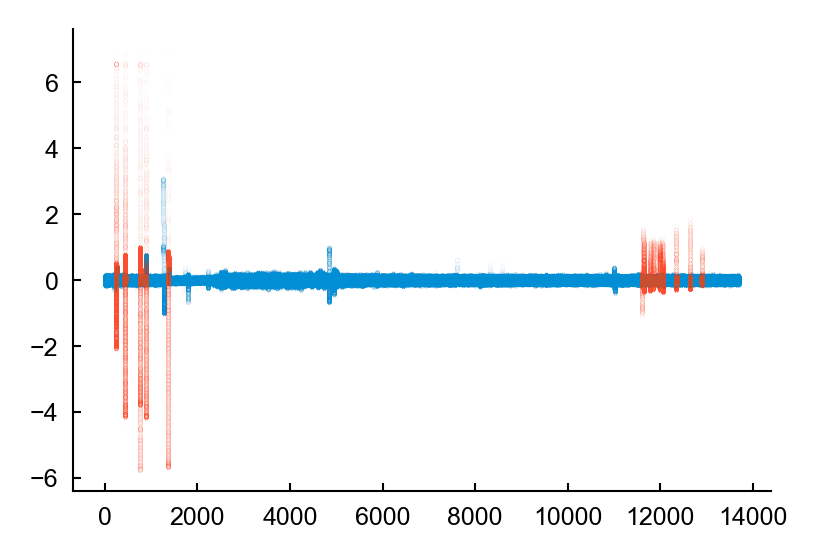

In [30]:
plt.scatter(time_vals[~noisy_times], lfp[~noisy_times][:, electrode_num])
plt.scatter(time_vals[noisy_times], lfp[noisy_times][:, electrode_num])
plt.show()

In [31]:
bad_electrode_df

,window_start,window_end,max_vals,bad_electrodes,num_bad_electrodes
84,1260.0,1275.0,"[0.42343396500963765, 0.4607065732720574, 0.47...","[4, 7, 43, 47]",4


In [32]:
row = bad_electrode_df.iloc[0]

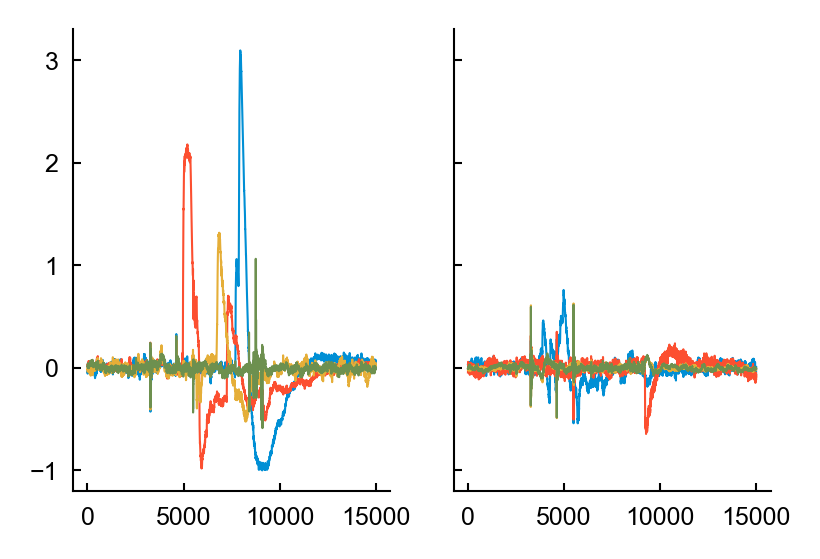

In [34]:
fig, axs = plt.subplots(1, 2, sharey=True)
window_data = lfp[int(row.window_start/dt):int((row.window_end)/dt)]

bad_electrode_inds = np.argsort(row.max_vals)[::-1][:row.num_bad_electrodes]
good_electrode_inds = np.argsort(row.max_vals)[::-1][row.num_bad_electrodes:]

ax = axs[0]
ax.plot(window_data[:, bad_electrode_inds])

ax = axs[1]
ax.plot(window_data[:, good_electrode_inds[:4]])

plt.show()